#### Achtung: Dieses Notebook benötigt die _aktuellste_ next-Version von PyDelta

Installation mit

```bash
pip install -U https://github.com/fotis007/pydelta@next
```

In [119]:
%pylab inline
mpl.style.use('ggplot')
import delta
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
de = delta.Corpus('/home/tv/git/pydelta/corpus_DE')
de1000 = de.get_mfw_table(2000)
z = delta.registry.z_score(de1000)

Da wir die z-Scores bereits bestimmt haben, müssen wir nun nur noch 'den Rest' der Funktionen rechnen:

In [75]:
methods = {
    'cosine_delta' : delta.registry.delta('cosine'),
    'burrows_delta': delta.registry.delta('manhattan'),
    'eders_delta'  : delta.CompositeDeltaFunction('manhattan-eder_std', name='eders_delta', register=False)
}

Nun einmal ein Experiment mit Cosine und unmanipuliertem Z-Corpus:

In [76]:
dist = delta.registry.cosine(z)
clust = delta.Clustering(dist).fclustering()
print(dist.evaluate(), clust.evaluate(), sep='\n')

F-Ratio         0.313304
Fisher's LD     2.329302
Simple Score    3.837367
dtype: float64
Cluster Errors         2.000000
Adjusted Rand Index    0.932358
Homogeneity            0.981365
Completeness           0.984136
V Measure              0.982749
Purity                 0.973333
Entropy                0.018635
dtype: float64


### Simulation von Outliern durch Manipulation der z-Scores

Um Outlier zu simulieren, manipulieren wir in der Tabelle der $z$-Scores zunächst zufällig jeweils $n$ verschiedene Werte, indem wir sie deutlich vergrößern.

In [23]:
all_z = z.unstack()
all_z.quantile(0.995), all_z.max(), all_z.min(), all_z.mean()

(4.0857283197106309,
 8.5447839840064788,
 -3.6663227759234687,
 -1.4731919388092743e-17)

Der Plan ist, jeweils $n$ Einträge zufällig zu wählen und sie dabei zu erhöhen, sagen wir mal um 5.

In [97]:
n = range(0,5001,25)

Wir bauen einen Dataframe für die Ergebnisse:

In [98]:
distance_eval = dist.evaluate().index.tolist()
cluster_eval = clust.evaluate().index.tolist()
all_eval = distance_eval + cluster_eval
idx = pd.MultiIndex.from_product([methods.keys(), n], names=['Method', 'Outliers'])
results = pd.DataFrame(index=idx, columns=pd.Index(all_eval))

In [99]:
for n_fakes in n:
    zz = delta.Corpus(z)
    for manip_count in range(0, n_fakes):
        r = randint(z.index.size * z.columns.size)
        x, y = r % z.index.size, r % z.columns.size
        zz.iat[x,y] += 5
    for method in methods:
        func = methods[method]
        dist = func(zz)
        clust = delta.Clustering(dist).fclustering()
        d_scores = dist.evaluate()
        c_scores = clust.evaluate()
        results.loc[(method, n_fakes), d_scores.index] = d_scores
        results.loc[(method, n_fakes), c_scores.index] = c_scores
        results.loc[(method, n_fakes), 'Mean z'] = zz.unstack().mean()

In [107]:
results.loc['burrows_delta']

,F-Ratio,Fisher's LD,Simple Score,Cluster Errors,Adjusted Rand Index,Homogeneity,Completeness,V Measure,Purity,Entropy,Mean z
Outliers,,,,,,,,,,,
0,0.466499,0.864265,2.43904,9,0.660328,0.902454,0.926885,0.914506,0.826667,0.0975459,-1.473192e-17
25,0.466945,0.852585,2.43766,9,0.660328,0.902454,0.926885,0.914506,0.826667,0.0975459,8.333333e-04
50,0.467349,0.864784,2.43599,9,0.660328,0.902454,0.926885,0.914506,0.826667,0.0975459,1.666667e-03
75,0.468828,0.864194,2.43886,9,0.660328,0.902454,0.926885,0.914506,0.826667,0.0975459,2.500000e-03
100,0.469315,0.876988,2.44526,8,0.711036,0.918274,0.935533,0.926823,0.853333,0.0817263,3.333333e-03
125,0.469542,0.856082,2.44891,8,0.711036,0.918274,0.935533,0.926823,0.853333,0.0817263,4.166667e-03
150,0.469714,0.868155,2.4497,9,0.660328,0.902454,0.926885,0.914506,0.826667,0.0975459,5.000000e-03
175,0.471052,0.895322,2.45424,8,0.711036,0.918274,0.935533,0.926823,0.853333,0.0817263,5.833333e-03
200,0.471407,0.861197,2.43317,9,0.672894,0.907076,0.92723,0.917042,0.826667,0.0929243,6.666667e-03


Bei **Cosine Delta** sieht man die Differenzen graduell schlechter werden, das Clustering ist jedoch bis zu 2500 manipulierten Werten stabil:

(<matplotlib.axes._subplots.AxesSubplot at 0x7fa57e9dfe80>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa57ea84128>)

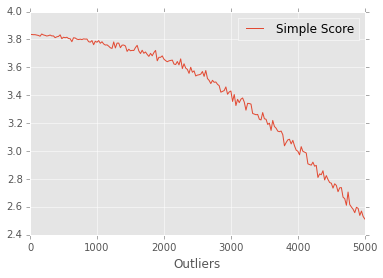

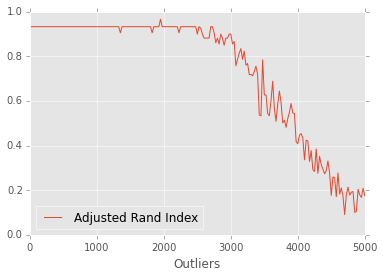

In [120]:
results.loc['cosine_delta'].plot.line(y='Simple Score'), \
results.loc['cosine_delta'].plot.line(y='Adjusted Rand Index')

**Burrows' Delta** indes ist viel weniger stabil (oder es ist ein Fehler drin), insbesondere beim Clustering:

(<matplotlib.axes._subplots.AxesSubplot at 0x7fa57eaf8048>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa57eb18208>)

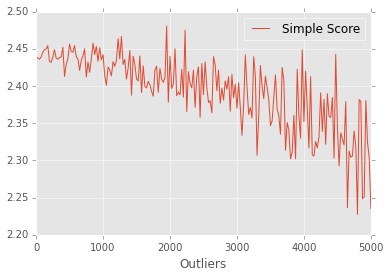

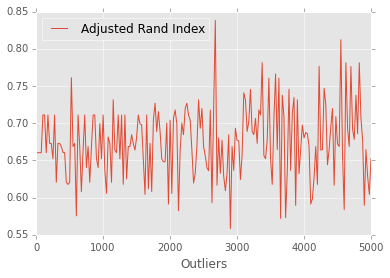

In [121]:
results.loc['burrows_delta'].plot.line(y='Simple Score'), results.loc['burrows_delta'].plot.line(y='Adjusted Rand Index')

Eder's Delta:

(<matplotlib.axes._subplots.AxesSubplot at 0x7fa57eb87a58>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa57ebdfb70>)

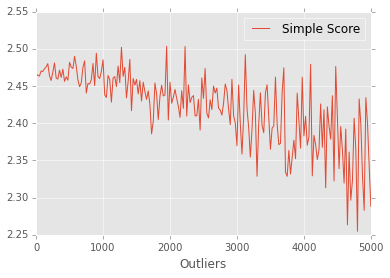

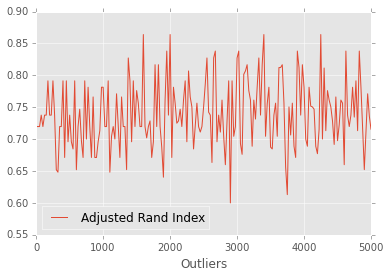

In [122]:
results.loc['eders_delta'].plot.line(y='Simple Score'), \
results.loc['eders_delta'].plot.line(y='Adjusted Rand Index')